In [16]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import vgg11, VGG11_Weights

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) 


## Helper Functions & Classes

In [17]:
# Hyperparameters
valid_size = 0.2
batch_size = 10
lr=0.001
n_epochs = 100

# Parameter Definition
num_workers = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

random_seed = 42
torch.manual_seed(random_seed)

# Define denormalizer
de_mean = [-mean/std for mean, std in zip(mean, std)]
de_std = [1/std for std in std]
denormalizer = transforms.Normalize(mean=de_mean, std=de_std)

def spilt_train_valid(train_dataset, valid_set_size):
    valid_set_size = int(valid_set_size * len(train_dataset))
    train_set_size = len(train_dataset) - valid_set_size
    return random_split(train_dataset, [train_set_size, valid_set_size])

def load_cifar10(is_train, transform):
    return datasets.CIFAR10(root='data', train=is_train, 
                            transform=transform, download=True)

def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def plot_confusion_matrix(conf_matrix, class_names, normalize=False, ax_display=True, title='Confusion Matrix'):
    _, ax = plt.subplots(figsize=(8,6))
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues,ax=ax, xticks_rotation=45, values_format='.2f')
    else:
        conf_matrix = conf_matrix.astype('int')
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues,ax=ax, xticks_rotation=45, values_format='d')
    if ax_display is False:
        left, right = plt.xlim()
        ax.spines['left'].set_position(('data', left))
        ax.spines['right'].set_position(('data', right))
        for edge_i in ['top', 'bottom', 'right', 'left']:
            ax.spines[edge_i].set_edgecolor("white")
    plt.title(title, fontdict={'size': 14})
    plt.tight_layout()
    plt.ylabel('True label', fontdict={'size': 14})
    plt.xlabel('Predicted label', fontdict={'size': 14})
    plt.show()

def plot_class_samples(samples, preds, values, title='Examples'):
  plt.figure(figsize=(12, 6))
  for idx in range(10):
      plt.subplot(2, 5, idx+1)
      img = denormalizer(samples[idx]).cpu().numpy()
      plt.imshow(np.transpose(img, (1, 2, 0))) 
      plt.title('True: {:s} (Pred: {:s})'.format(class_names[idx], class_names[preds[idx]]), 
                fontdict={'size': 10},
                color=("green" if preds[idx]==idx else "red"))
      plt.xlabel('Confidence value: {:.2f}'.format(values[idx]), 
                fontdict={'size'   : 10})
      plt.yticks([])
      plt.xticks([])
  plt.suptitle(title, fontdict={'size': 14})
  plt.tight_layout()
  plt.show()

## Data Augumentation

In [18]:
train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomGrayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                                ])

test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                                ])

## Data Loading

In [19]:
# Load train, validation and test datasets as iterators
# Data
train_ds = load_cifar10(is_train=True, transform=train_transform)
test_ds = load_cifar10(is_train=False, transform=test_transform)
train_ds, valid_ds = spilt_train_valid(train_ds, valid_size)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                         shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                         shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


## Network Definition

In [21]:
model = vgg11(VGG11_Weights.IMAGENET1K_V1)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


## Training

======================== Epoch: 1 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.70it/s]


Train loss: 1.105, Train acc: 63.4%


100%|██████████| 1000/1000 [00:07<00:00, 134.70it/s]


Valid loss: 0.675, Valid acc: 77.4%
Validation loss decreased (inf --> 0.675).


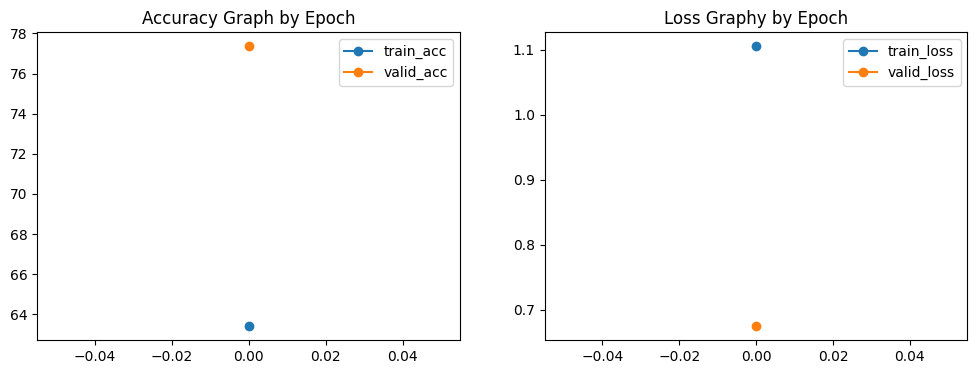

======================== Epoch: 2 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.70it/s]


Train loss: 0.623, Train acc: 79.6%


100%|██████████| 1000/1000 [00:07<00:00, 133.78it/s]


Valid loss: 0.619, Valid acc: 79.5%
Validation loss decreased (0.675 --> 0.619).


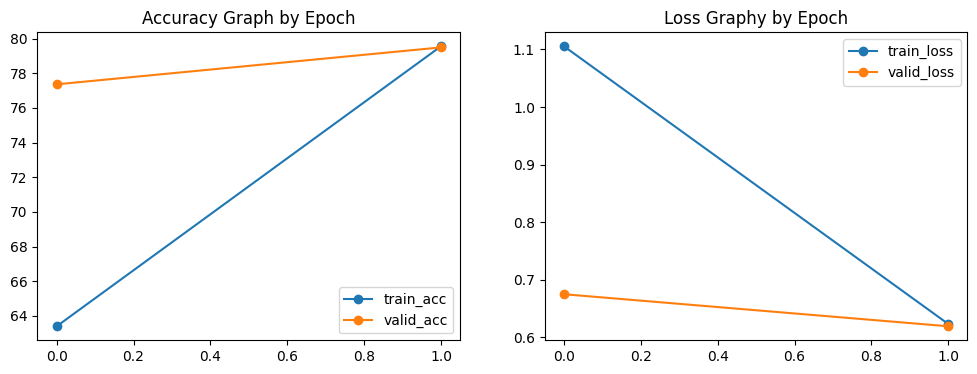

======================== Epoch: 3 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.64it/s]


Train loss: 0.484, Train acc: 84.1%


100%|██████████| 1000/1000 [00:07<00:00, 134.96it/s]


Valid loss: 0.567, Valid acc: 81.4%
Validation loss decreased (0.619 --> 0.567).


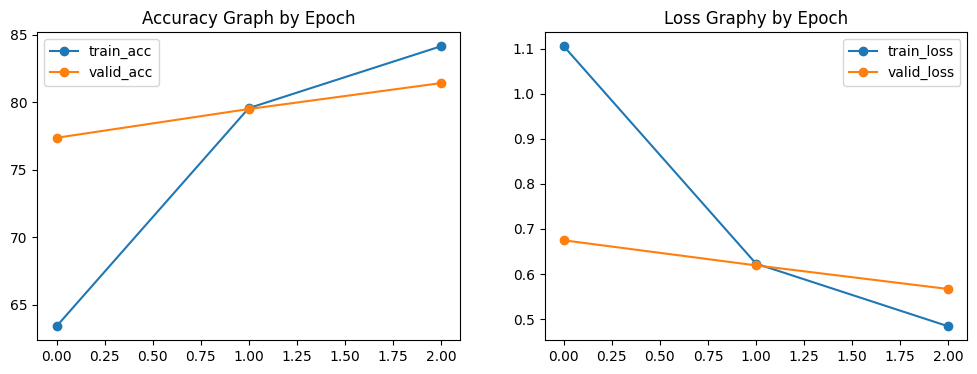

======================== Epoch: 4 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.78it/s]


Train loss: 0.393, Train acc: 87.0%


100%|██████████| 1000/1000 [00:07<00:00, 135.87it/s]


Valid loss: 0.478, Valid acc: 84.2%
Validation loss decreased (0.567 --> 0.478).


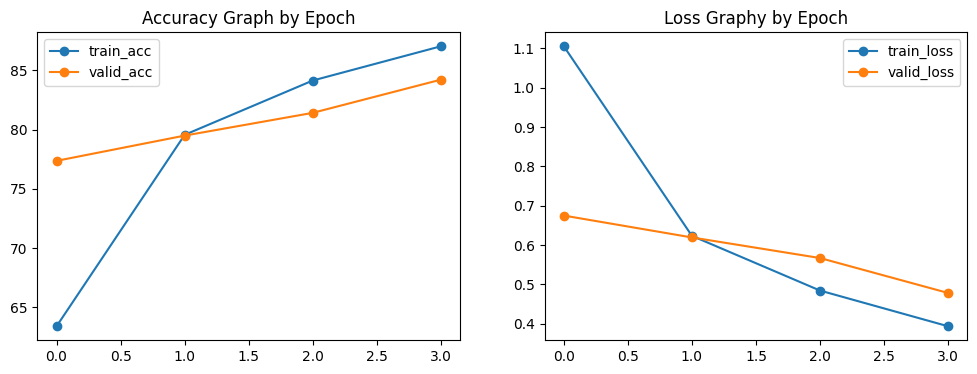

======================== Epoch: 5 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.75it/s]


Train loss: 0.334, Train acc: 89.0%


100%|██████████| 1000/1000 [00:07<00:00, 136.88it/s]


Valid loss: 0.479, Valid acc: 84.3%


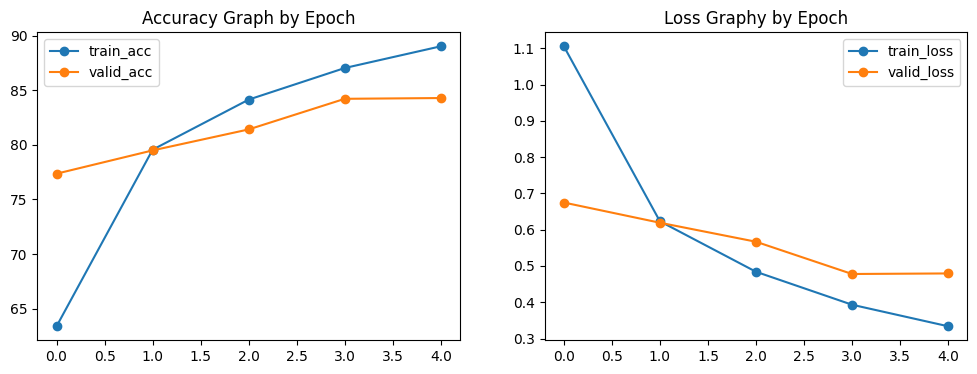

======================== Epoch: 6 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.87it/s]


Train loss: 0.276, Train acc: 90.8%


100%|██████████| 1000/1000 [00:07<00:00, 136.30it/s]


Valid loss: 0.490, Valid acc: 84.2%


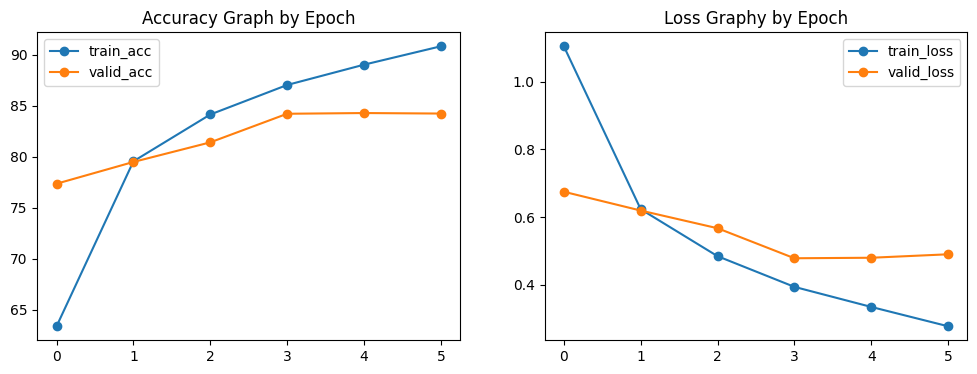

======================== Epoch: 7 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.83it/s]


Train loss: 0.234, Train acc: 92.3%


100%|██████████| 1000/1000 [00:07<00:00, 133.96it/s]


Valid loss: 0.514, Valid acc: 84.7%


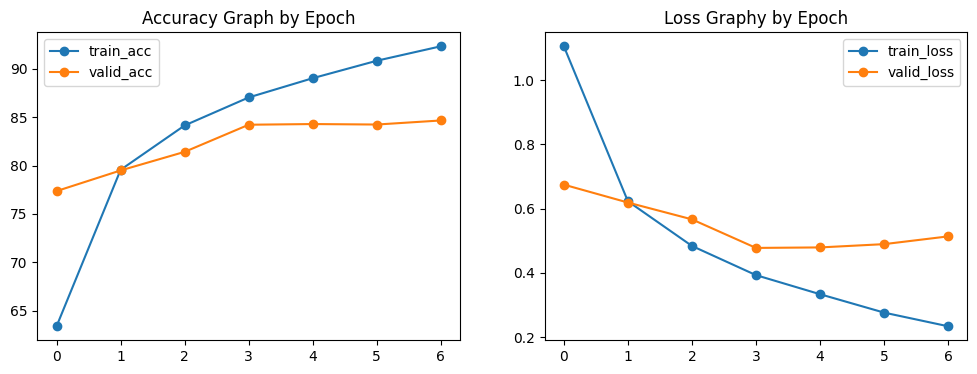

======================== Epoch: 8 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.71it/s]


Train loss: 0.209, Train acc: 93.3%


100%|██████████| 1000/1000 [00:07<00:00, 134.82it/s]


Valid loss: 0.491, Valid acc: 84.3%


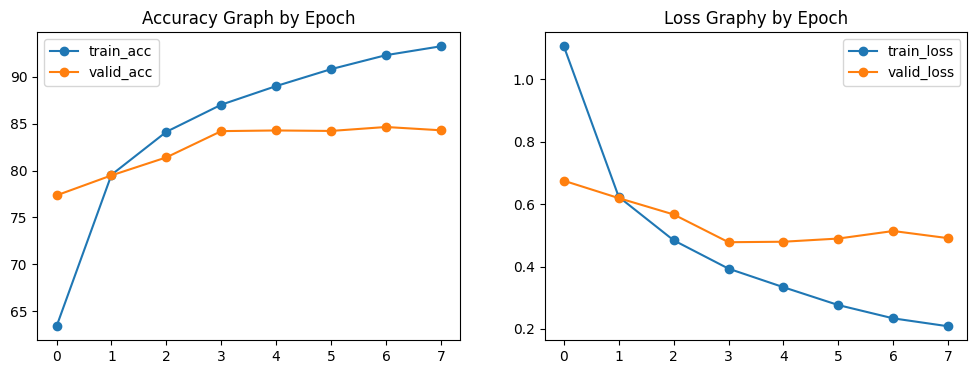

======================== Epoch: 9 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.77it/s]


Train loss: 0.180, Train acc: 94.2%


100%|██████████| 1000/1000 [00:07<00:00, 133.78it/s]


Valid loss: 0.456, Valid acc: 85.8%
Validation loss decreased (0.478 --> 0.456).


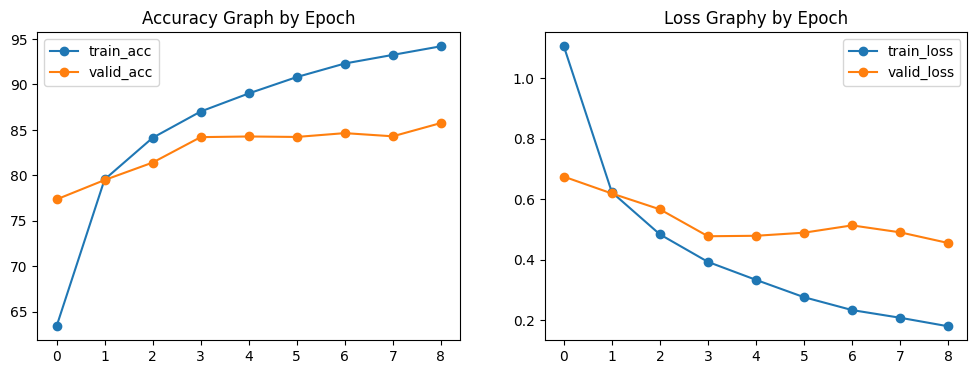

======================== Epoch: 10 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.76it/s]


Train loss: 0.157, Train acc: 94.9%


100%|██████████| 1000/1000 [00:07<00:00, 136.01it/s]


Valid loss: 0.493, Valid acc: 85.9%


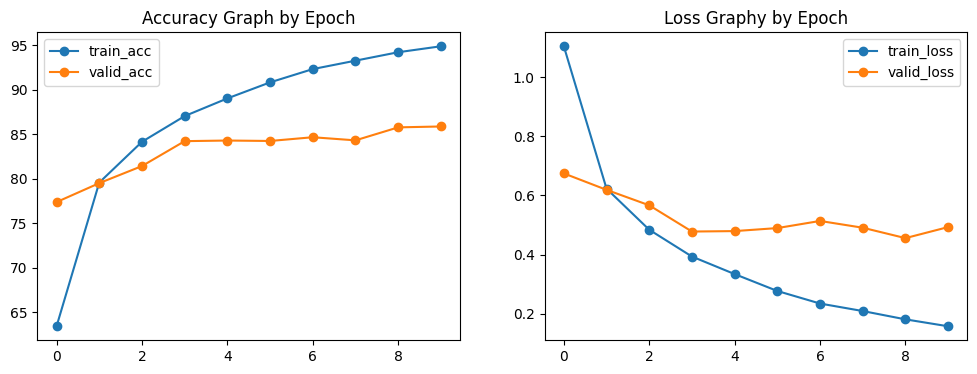

======================== Epoch: 11 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.80it/s]


Train loss: 0.136, Train acc: 95.7%


100%|██████████| 1000/1000 [00:07<00:00, 134.70it/s]


Valid loss: 0.493, Valid acc: 86.0%


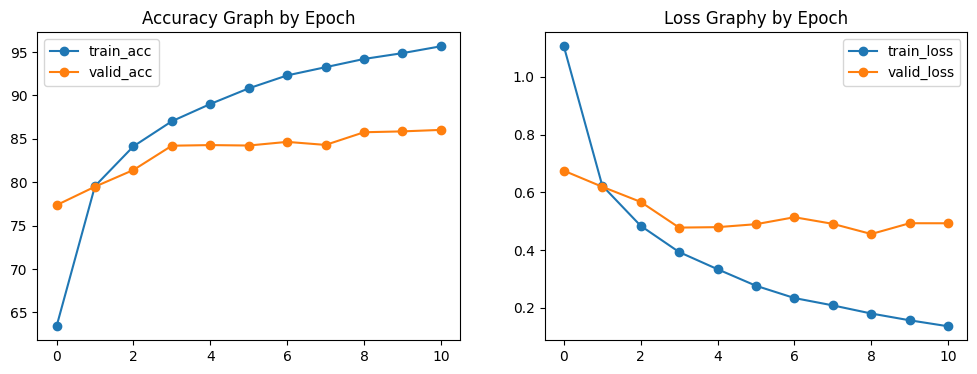

======================== Epoch: 12 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.71it/s]


Train loss: 0.120, Train acc: 96.0%


100%|██████████| 1000/1000 [00:07<00:00, 133.91it/s]


Valid loss: 0.496, Valid acc: 85.7%


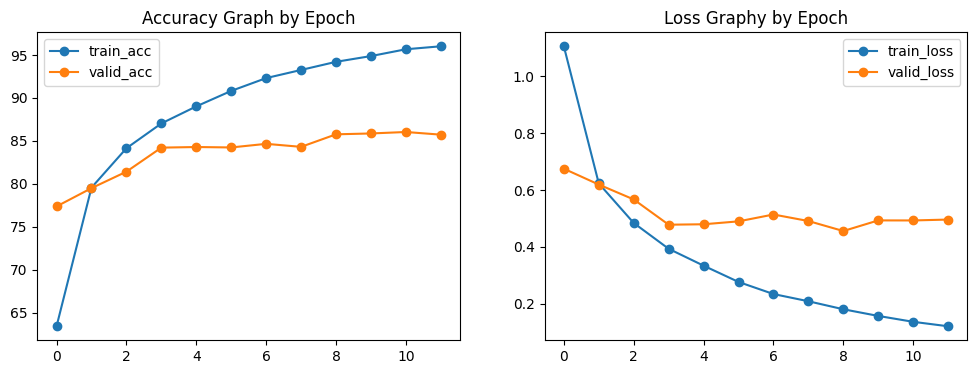

======================== Epoch: 13 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.82it/s]


Train loss: 0.111, Train acc: 96.5%


100%|██████████| 1000/1000 [00:07<00:00, 136.43it/s]


Valid loss: 0.542, Valid acc: 85.1%


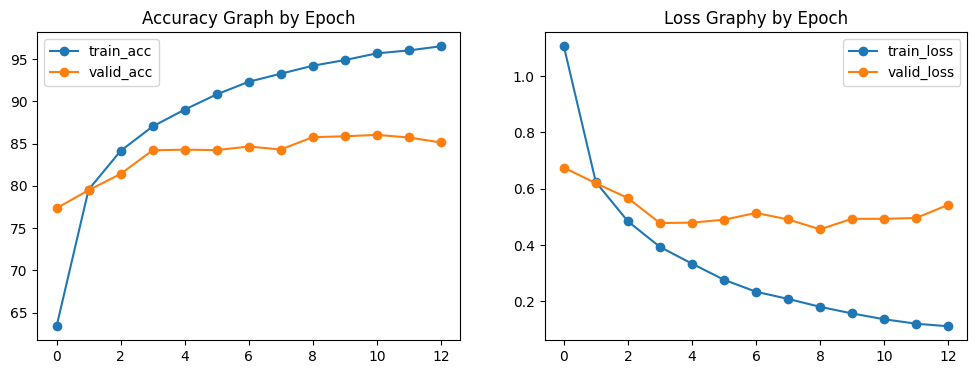

======================== Epoch: 14 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.80it/s]


Train loss: 0.100, Train acc: 96.8%


100%|██████████| 1000/1000 [00:07<00:00, 135.81it/s]


Valid loss: 0.556, Valid acc: 85.0%


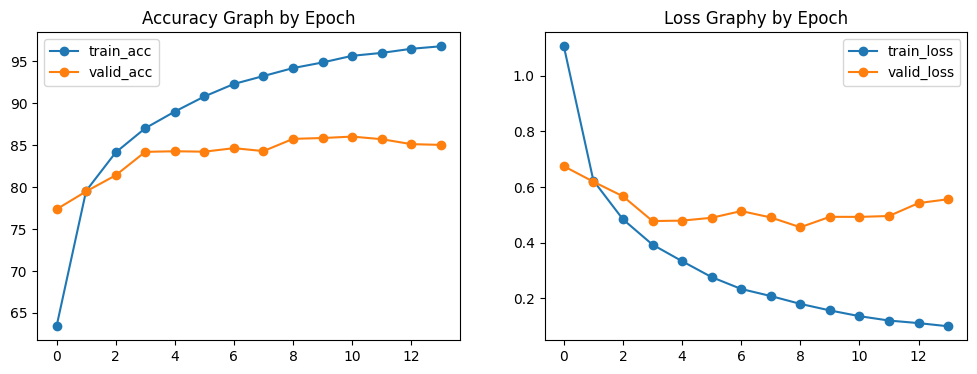

======================== Epoch: 15 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.81it/s]


Train loss: 0.094, Train acc: 97.0%


100%|██████████| 1000/1000 [00:07<00:00, 133.91it/s]


Valid loss: 0.592, Valid acc: 84.9%


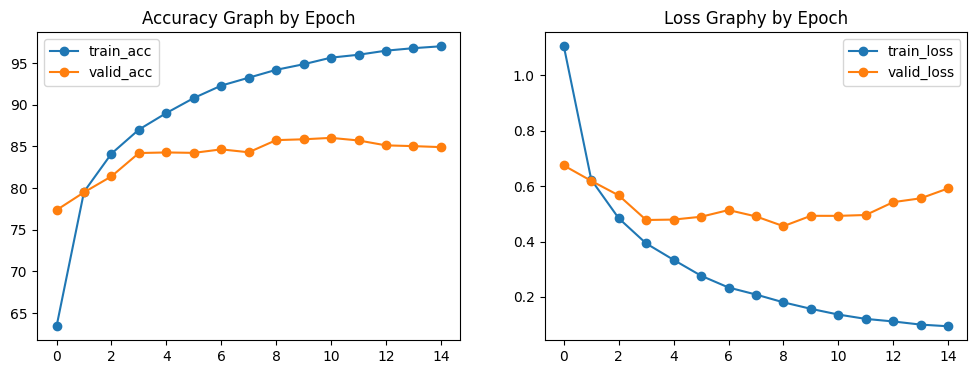

======================== Epoch: 16 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.80it/s]


Train loss: 0.081, Train acc: 97.4%


100%|██████████| 1000/1000 [00:07<00:00, 136.05it/s]


Valid loss: 0.566, Valid acc: 85.7%


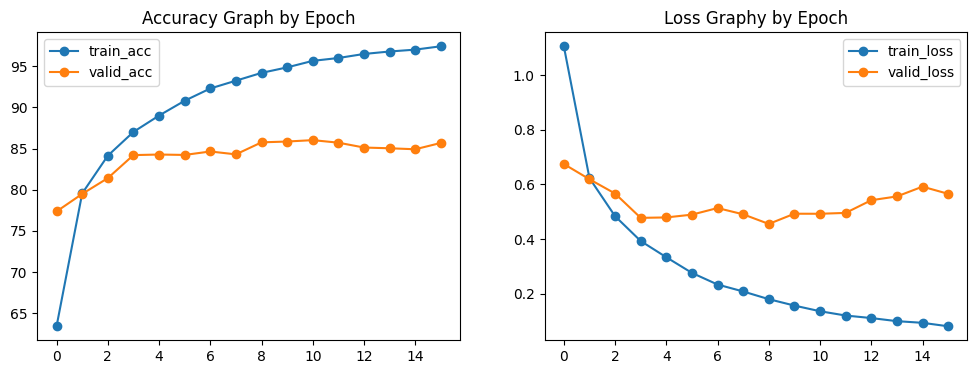

======================== Epoch: 17 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.92it/s]


Train loss: 0.074, Train acc: 97.6%


100%|██████████| 1000/1000 [00:07<00:00, 135.95it/s]


Valid loss: 0.536, Valid acc: 86.0%


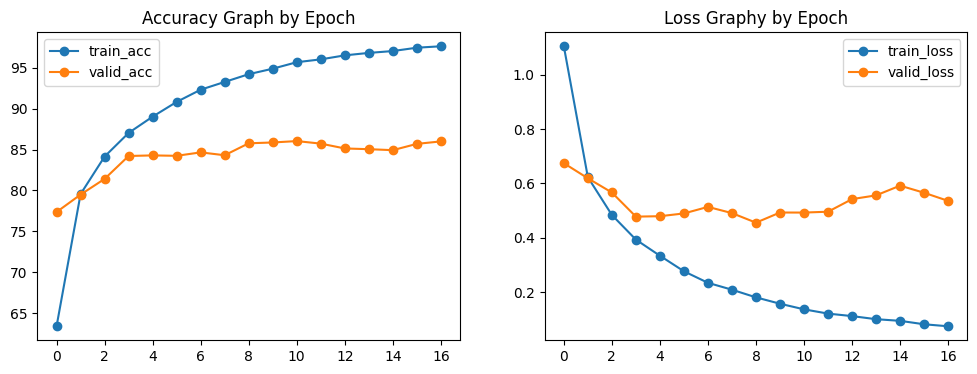

======================== Epoch: 18 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.87it/s]


Train loss: 0.065, Train acc: 98.0%


100%|██████████| 1000/1000 [00:07<00:00, 134.79it/s]


Valid loss: 0.557, Valid acc: 86.1%


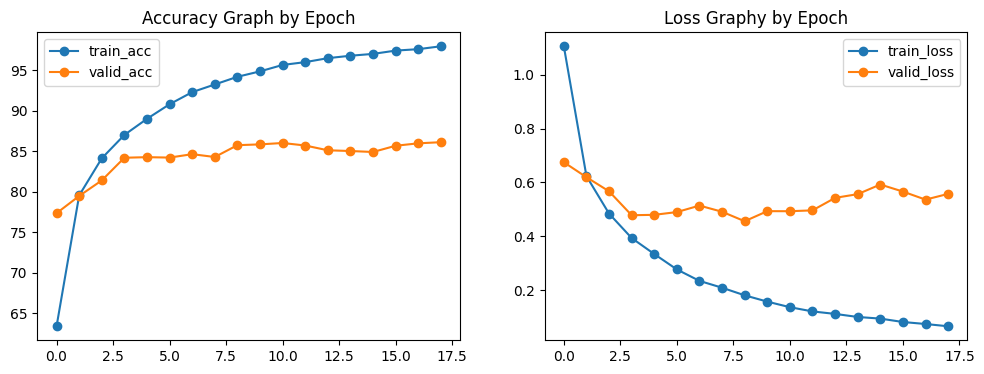

======================== Epoch: 19 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.72it/s]


Train loss: 0.065, Train acc: 97.9%


100%|██████████| 1000/1000 [00:07<00:00, 135.84it/s]


Valid loss: 0.584, Valid acc: 86.4%


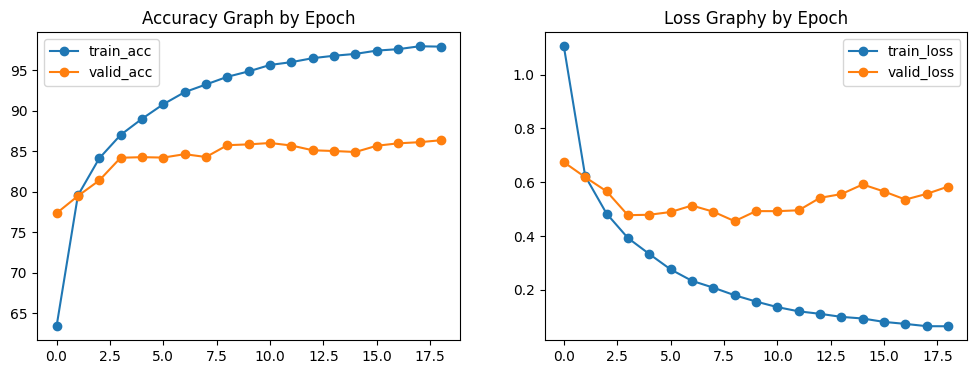

======================== Epoch: 20 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.80it/s]


Train loss: 0.063, Train acc: 98.0%


100%|██████████| 1000/1000 [00:07<00:00, 134.29it/s]


Valid loss: 0.554, Valid acc: 86.4%


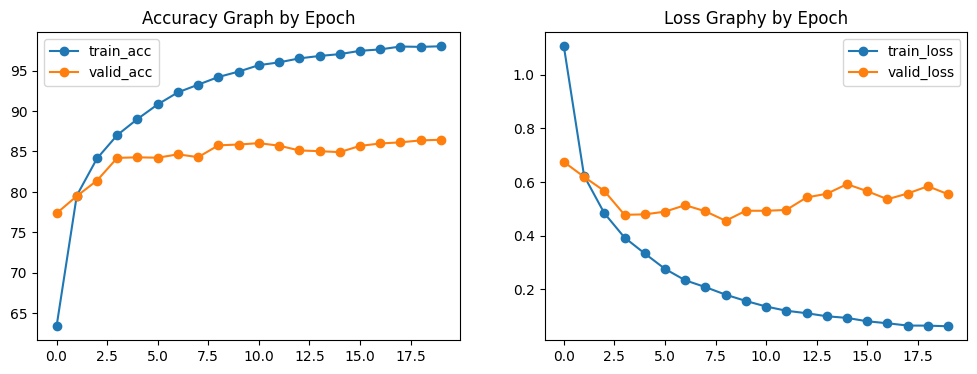

======================== Epoch: 21 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.85it/s]


Train loss: 0.055, Train acc: 98.3%


100%|██████████| 1000/1000 [00:07<00:00, 135.86it/s]


Valid loss: 0.571, Valid acc: 87.1%


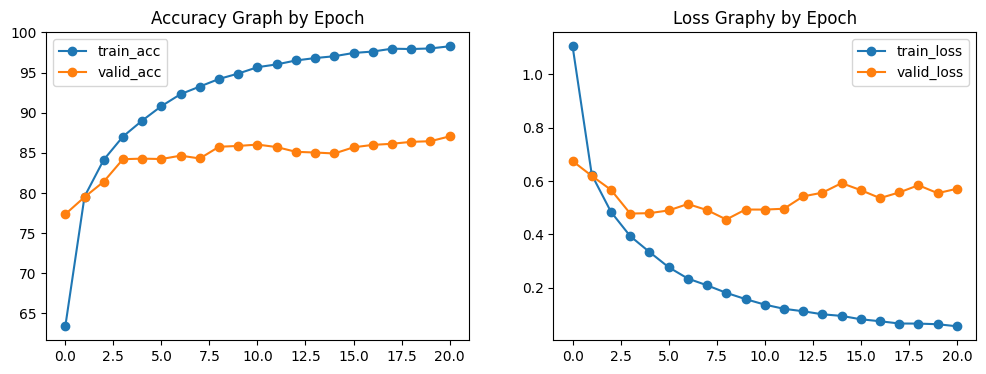

======================== Epoch: 22 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.87it/s]


Train loss: 0.058, Train acc: 98.2%


100%|██████████| 1000/1000 [00:07<00:00, 135.63it/s]


Valid loss: 0.590, Valid acc: 85.7%


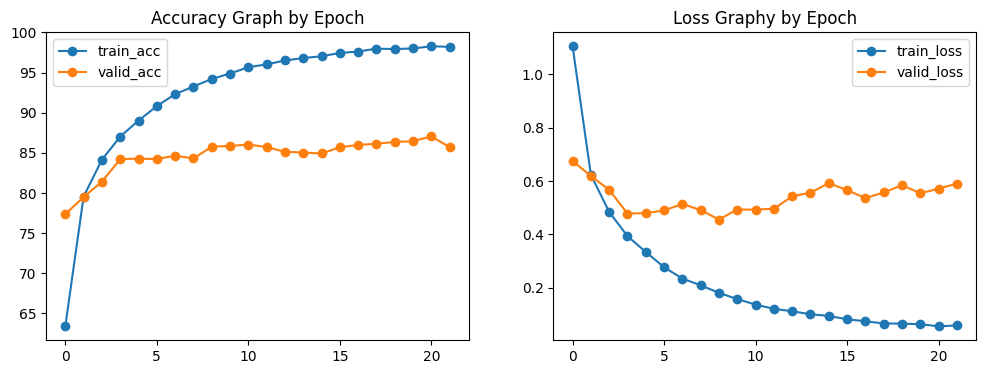

======================== Epoch: 23 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.63it/s]


Train loss: 0.053, Train acc: 98.4%


100%|██████████| 1000/1000 [00:07<00:00, 128.15it/s]


Valid loss: 0.550, Valid acc: 86.8%


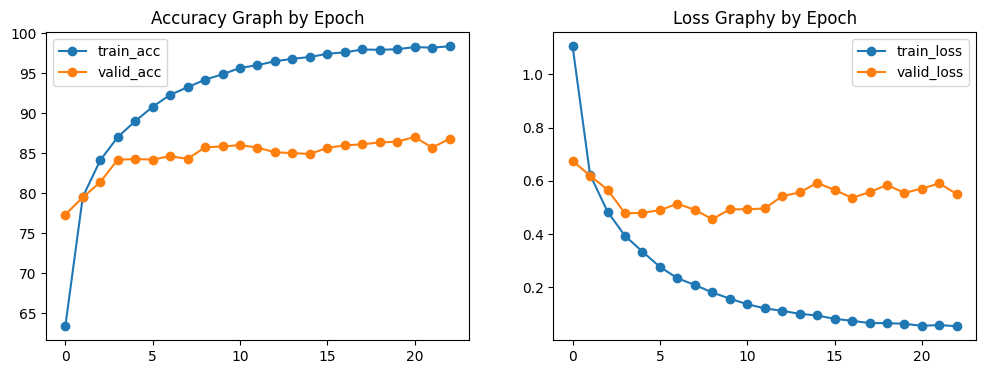

======================== Epoch: 24 ========================


100%|██████████| 4000/4000 [01:32<00:00, 43.40it/s]


Train loss: 0.050, Train acc: 98.5%


100%|██████████| 1000/1000 [00:07<00:00, 136.39it/s]


Valid loss: 0.568, Valid acc: 87.1%


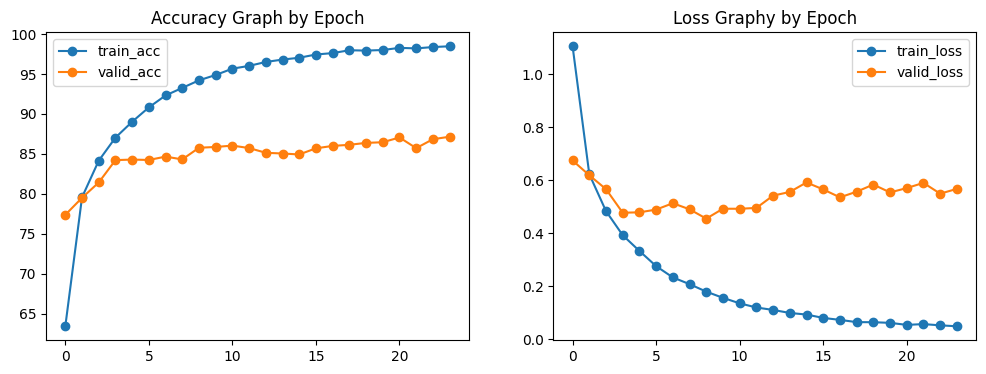

======================== Epoch: 25 ========================


100%|██████████| 4000/4000 [01:32<00:00, 43.46it/s]


Train loss: 0.045, Train acc: 98.6%


100%|██████████| 1000/1000 [00:07<00:00, 134.50it/s]


Valid loss: 0.645, Valid acc: 85.6%


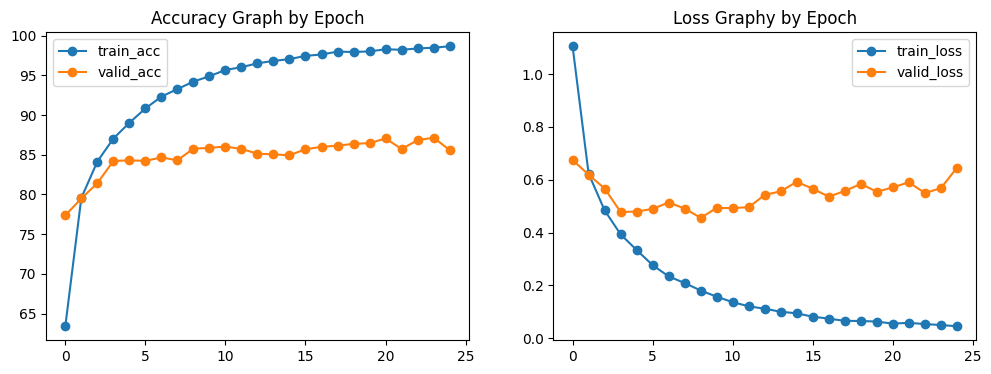

======================== Epoch: 26 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.59it/s]


Train loss: 0.044, Train acc: 98.7%


100%|██████████| 1000/1000 [00:07<00:00, 134.87it/s]


Valid loss: 0.538, Valid acc: 87.5%


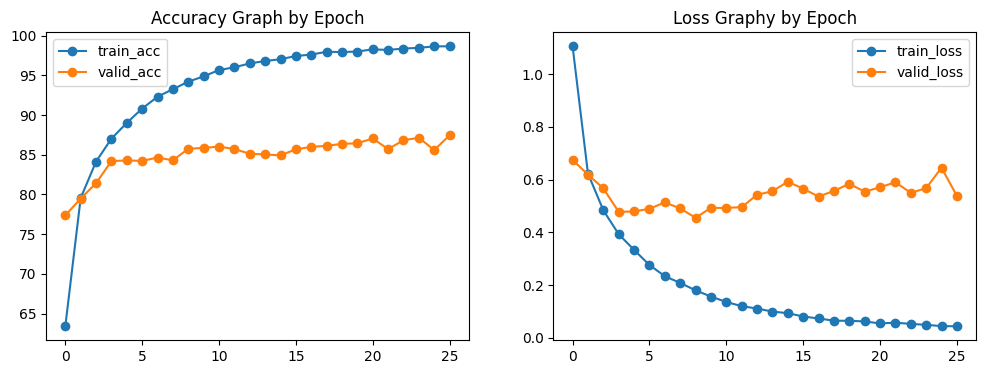

======================== Epoch: 27 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.65it/s]


Train loss: 0.039, Train acc: 98.8%


100%|██████████| 1000/1000 [00:07<00:00, 134.44it/s]


Valid loss: 0.597, Valid acc: 87.2%


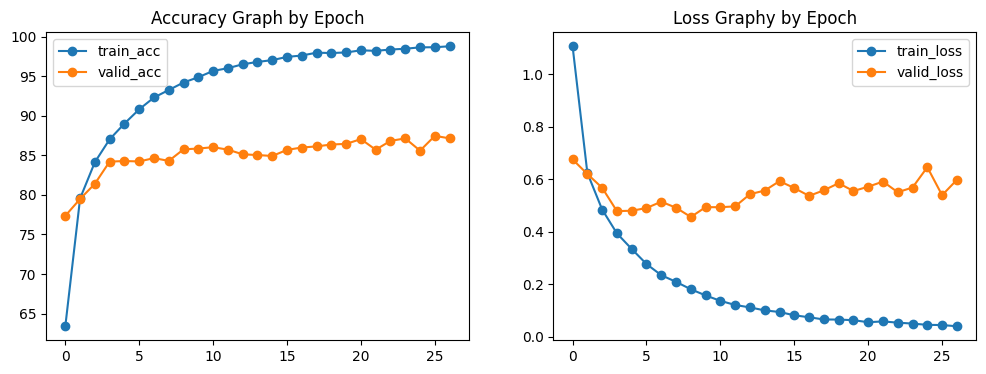

======================== Epoch: 28 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.62it/s]


Train loss: 0.039, Train acc: 98.8%


100%|██████████| 1000/1000 [00:07<00:00, 134.26it/s]


Valid loss: 0.669, Valid acc: 85.5%


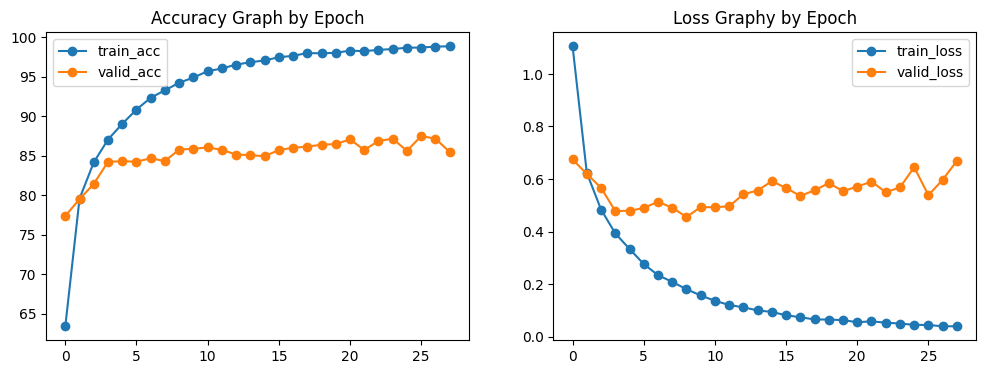

======================== Epoch: 29 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.65it/s]


Train loss: 0.038, Train acc: 98.8%


100%|██████████| 1000/1000 [00:07<00:00, 134.74it/s]


Valid loss: 0.598, Valid acc: 86.6%


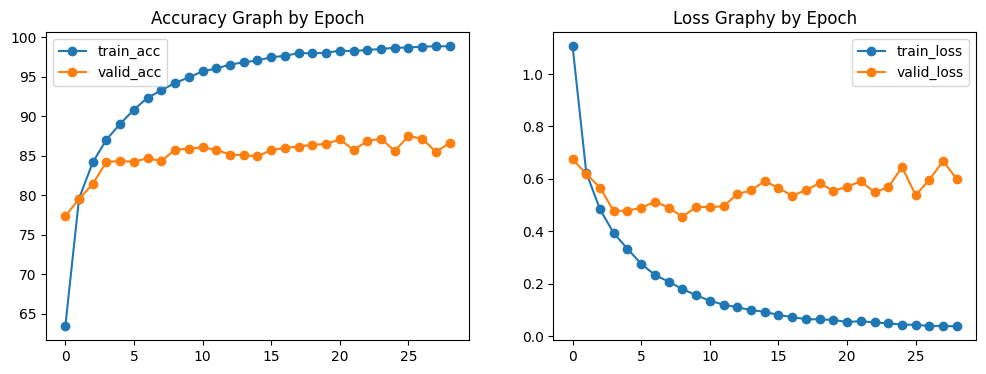

======================== Epoch: 30 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.67it/s]


Train loss: 0.036, Train acc: 98.9%


100%|██████████| 1000/1000 [00:07<00:00, 134.91it/s]


Valid loss: 0.582, Valid acc: 86.3%


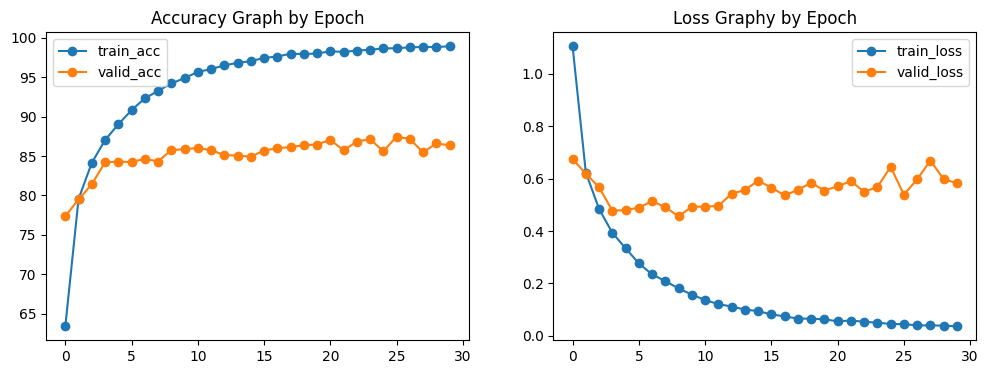

======================== Epoch: 31 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.66it/s]


Train loss: 0.039, Train acc: 98.8%


100%|██████████| 1000/1000 [00:07<00:00, 135.51it/s]


Valid loss: 0.566, Valid acc: 86.6%


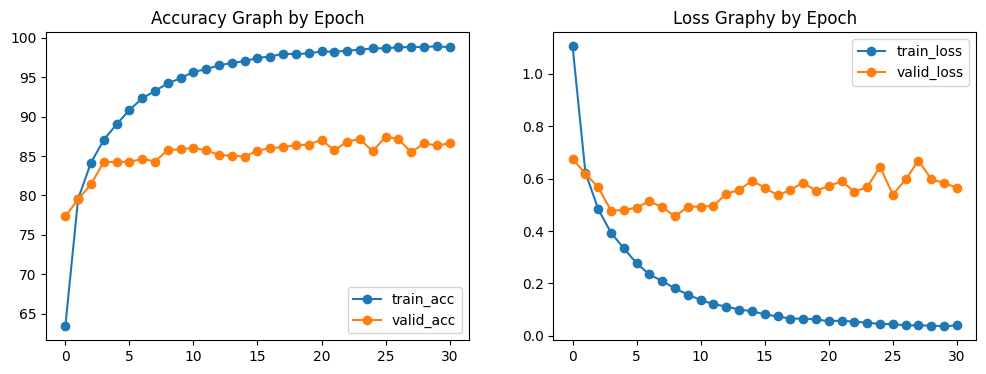

======================== Epoch: 32 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.62it/s]


Train loss: 0.035, Train acc: 98.9%


100%|██████████| 1000/1000 [00:07<00:00, 134.31it/s]


Valid loss: 0.622, Valid acc: 86.7%


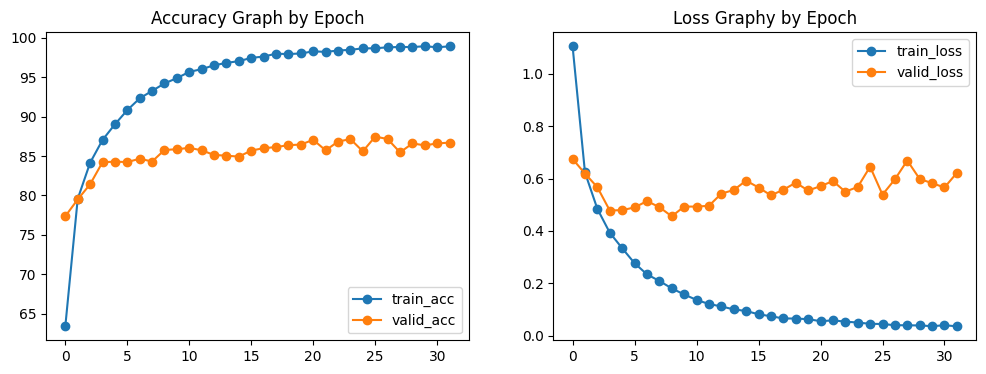

======================== Epoch: 33 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.64it/s]


Train loss: 0.033, Train acc: 99.0%


100%|██████████| 1000/1000 [00:07<00:00, 133.52it/s]


Valid loss: 0.590, Valid acc: 86.9%


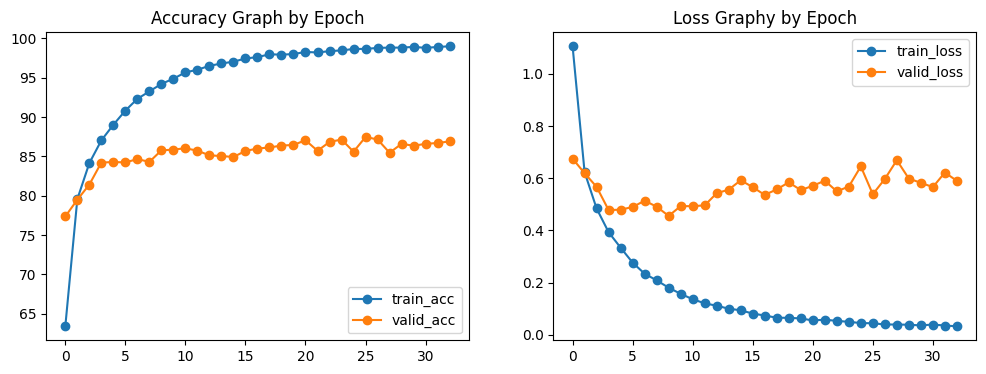

======================== Epoch: 34 ========================


100%|██████████| 4000/4000 [01:32<00:00, 43.24it/s]


Train loss: 0.031, Train acc: 99.0%


100%|██████████| 1000/1000 [00:07<00:00, 131.57it/s]


Valid loss: 0.698, Valid acc: 85.8%


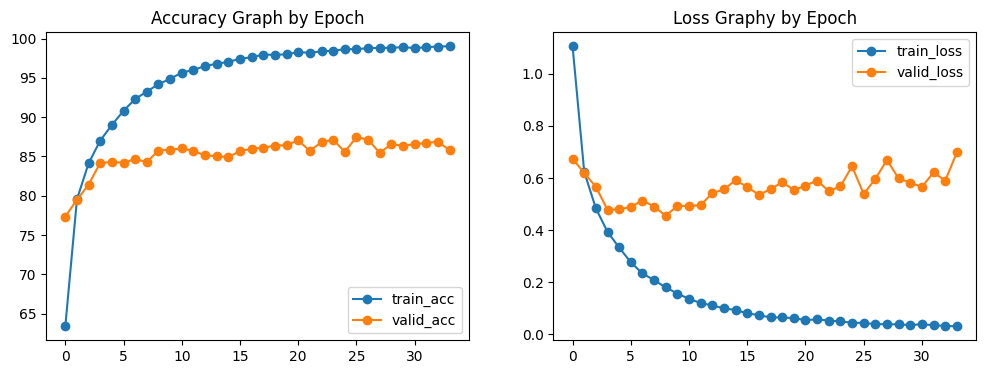

======================== Epoch: 35 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.54it/s]


Train loss: 0.030, Train acc: 99.1%


100%|██████████| 1000/1000 [00:07<00:00, 135.86it/s]


Valid loss: 0.605, Valid acc: 86.8%


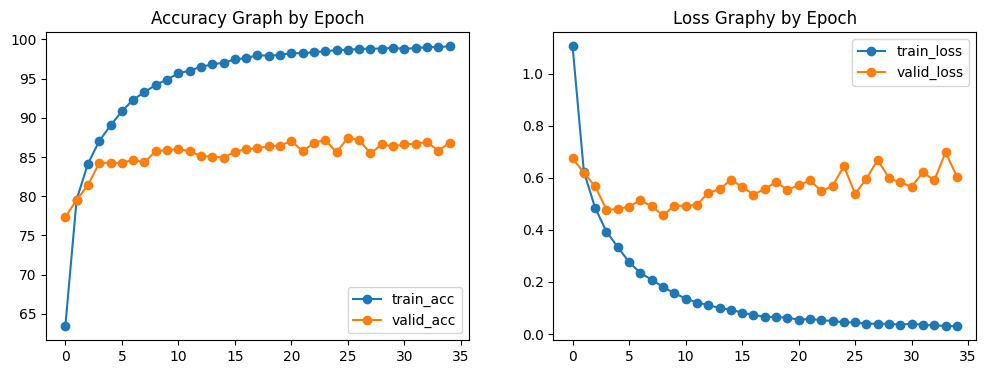

======================== Epoch: 36 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.63it/s]


Train loss: 0.027, Train acc: 99.2%


100%|██████████| 1000/1000 [00:07<00:00, 135.10it/s]


Valid loss: 0.631, Valid acc: 86.7%


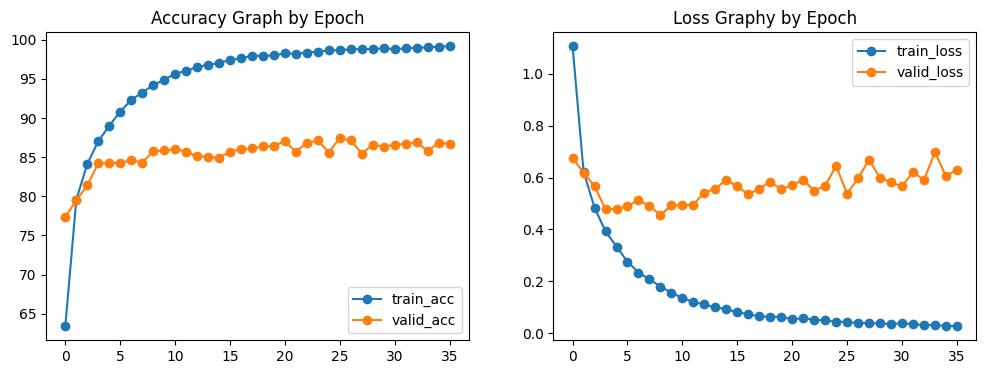

======================== Epoch: 37 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.55it/s]


Train loss: 0.029, Train acc: 99.1%


100%|██████████| 1000/1000 [00:07<00:00, 133.62it/s]


Valid loss: 0.610, Valid acc: 87.0%


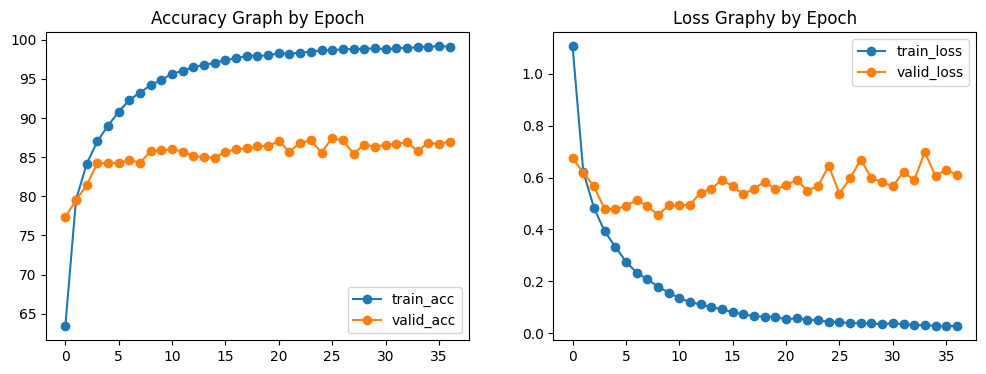

======================== Epoch: 38 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.49it/s]


Train loss: 0.027, Train acc: 99.1%


100%|██████████| 1000/1000 [00:07<00:00, 133.94it/s]


Valid loss: 0.681, Valid acc: 86.9%


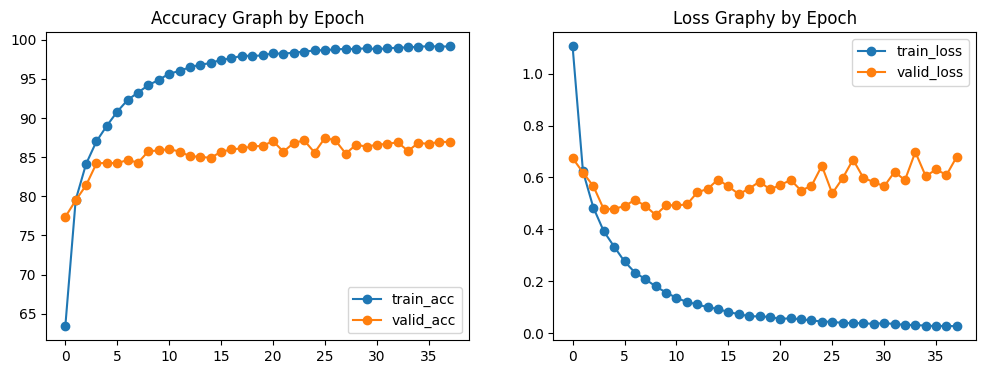

======================== Epoch: 39 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.50it/s]


Train loss: 0.028, Train acc: 99.2%


100%|██████████| 1000/1000 [00:07<00:00, 134.93it/s]


Valid loss: 0.647, Valid acc: 86.8%


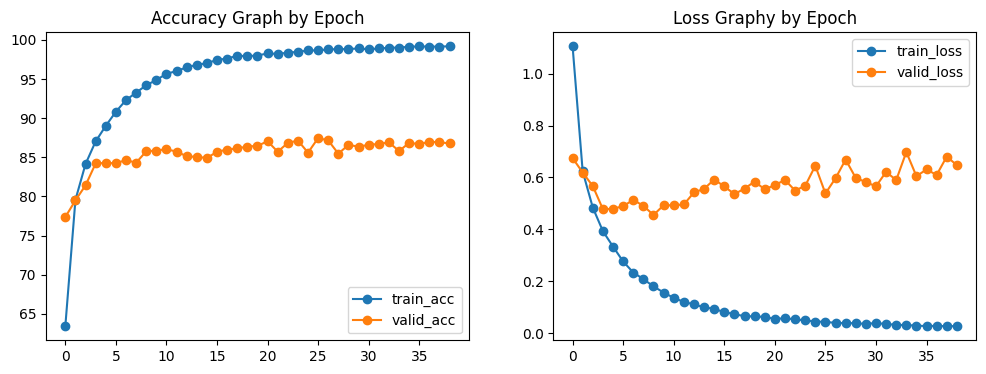

======================== Epoch: 40 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.55it/s]


Train loss: 0.024, Train acc: 99.2%


100%|██████████| 1000/1000 [00:07<00:00, 133.99it/s]


Valid loss: 0.619, Valid acc: 87.1%


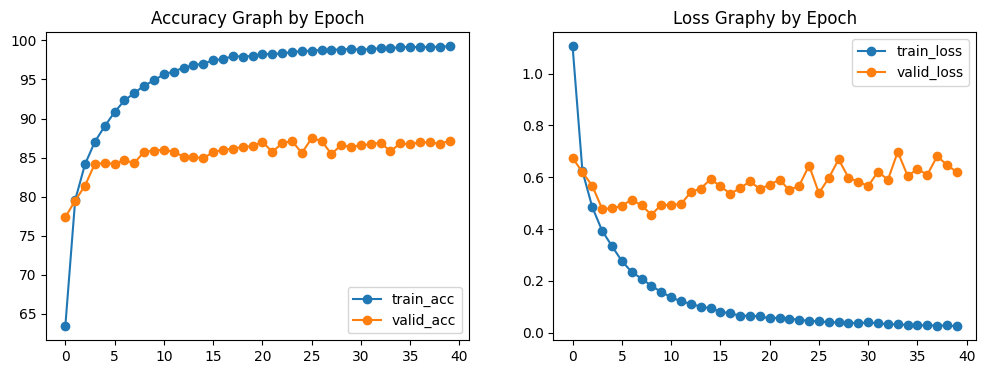

======================== Epoch: 41 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.56it/s]


Train loss: 0.024, Train acc: 99.2%


100%|██████████| 1000/1000 [00:07<00:00, 134.15it/s]


Valid loss: 0.689, Valid acc: 86.6%


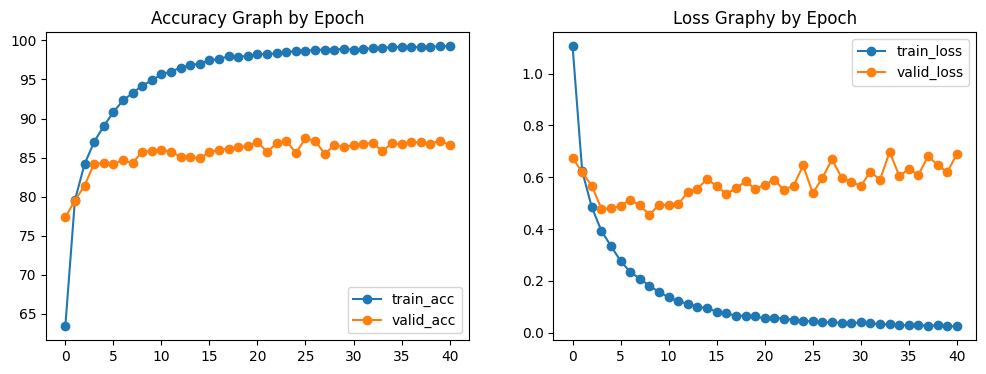

======================== Epoch: 42 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.59it/s]


Train loss: 0.024, Train acc: 99.3%


100%|██████████| 1000/1000 [00:07<00:00, 134.01it/s]


Valid loss: 0.659, Valid acc: 86.4%


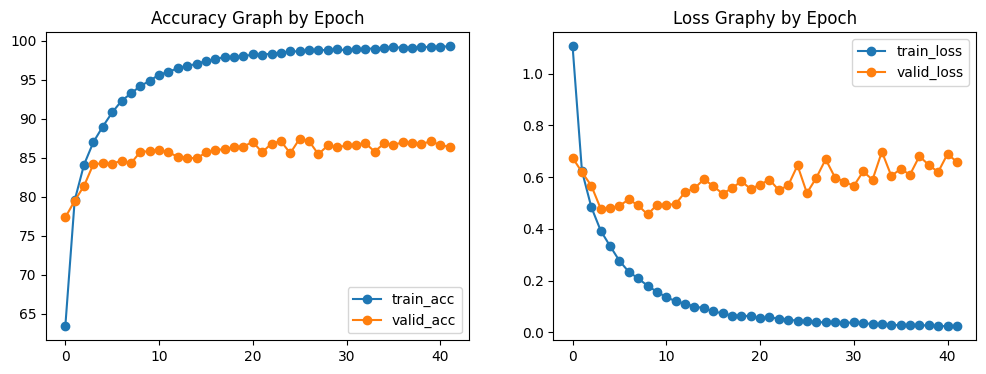

======================== Epoch: 43 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.55it/s]


Train loss: 0.025, Train acc: 99.3%


100%|██████████| 1000/1000 [00:07<00:00, 135.00it/s]


Valid loss: 0.616, Valid acc: 87.0%


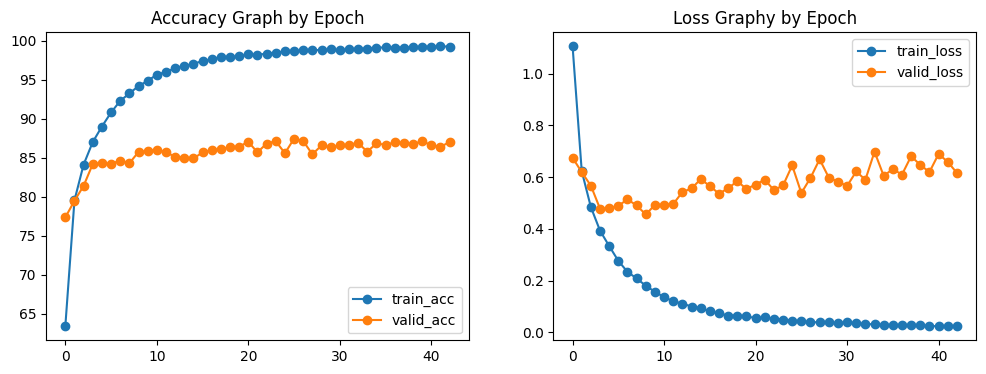

======================== Epoch: 44 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.71it/s]


Train loss: 0.027, Train acc: 99.2%


100%|██████████| 1000/1000 [00:07<00:00, 134.45it/s]


Valid loss: 0.581, Valid acc: 87.3%


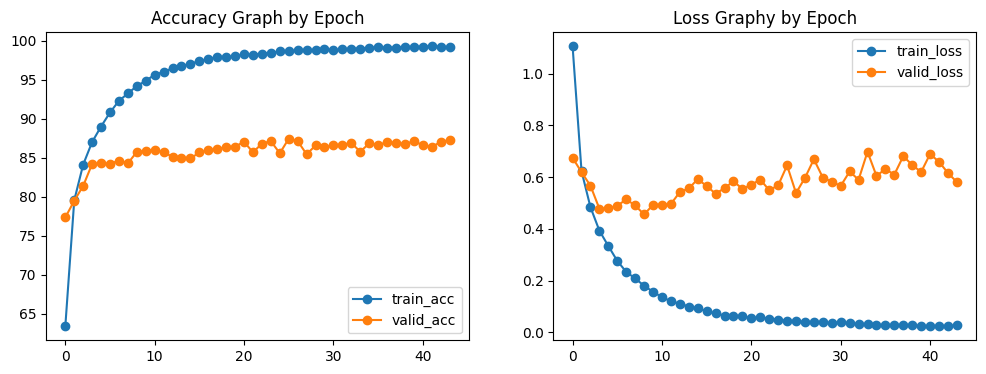

======================== Epoch: 45 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.60it/s]


Train loss: 0.023, Train acc: 99.3%


100%|██████████| 1000/1000 [00:07<00:00, 136.37it/s]


Valid loss: 0.665, Valid acc: 86.6%


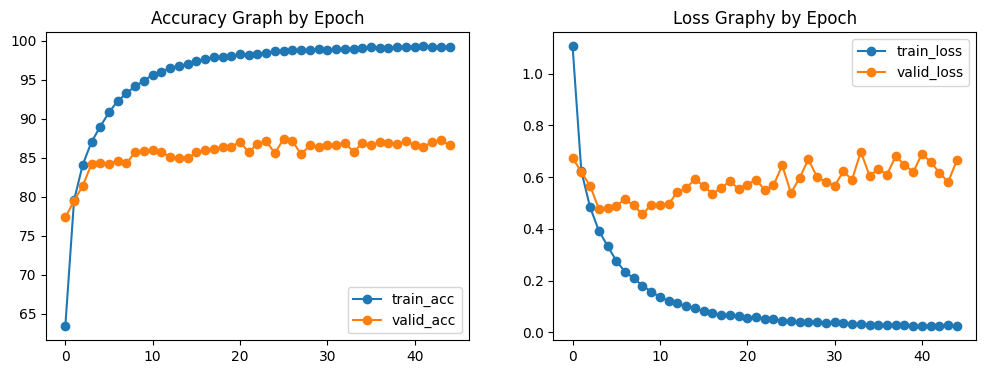

======================== Epoch: 46 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.59it/s]


Train loss: 0.025, Train acc: 99.3%


100%|██████████| 1000/1000 [00:07<00:00, 133.69it/s]


Valid loss: 0.634, Valid acc: 86.9%


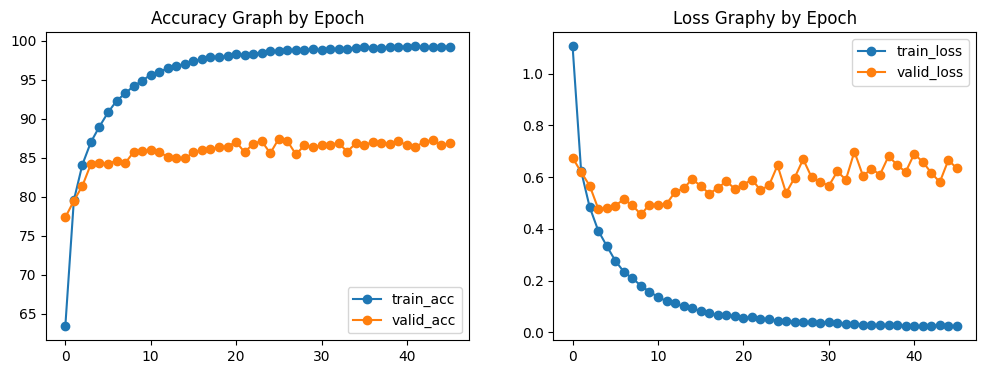

======================== Epoch: 47 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.62it/s]


Train loss: 0.019, Train acc: 99.4%


100%|██████████| 1000/1000 [00:07<00:00, 136.14it/s]


Valid loss: 0.640, Valid acc: 87.3%


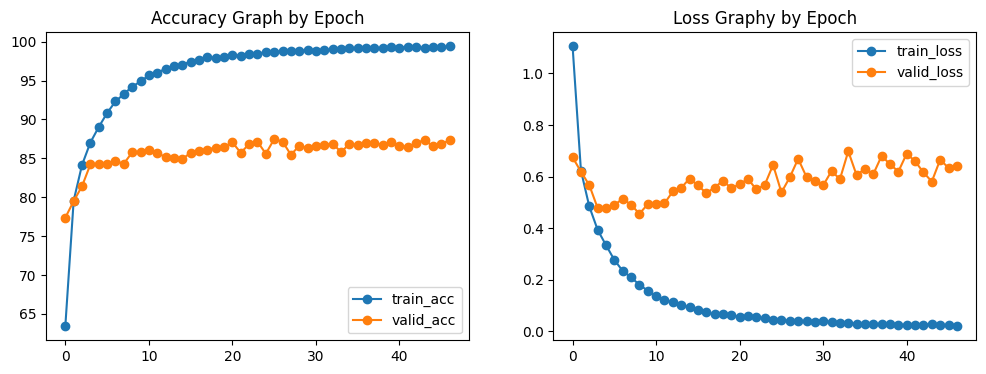

======================== Epoch: 48 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.56it/s]


Train loss: 0.021, Train acc: 99.4%


100%|██████████| 1000/1000 [00:07<00:00, 134.36it/s]


Valid loss: 0.671, Valid acc: 86.6%


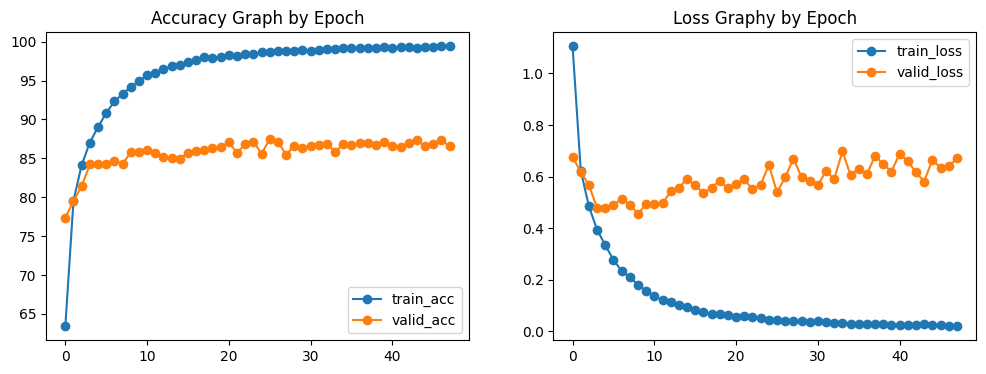

======================== Epoch: 49 ========================


100%|██████████| 4000/4000 [01:30<00:00, 43.99it/s]


Train loss: 0.020, Train acc: 99.4%


100%|██████████| 1000/1000 [00:07<00:00, 135.33it/s]


Valid loss: 0.679, Valid acc: 87.1%


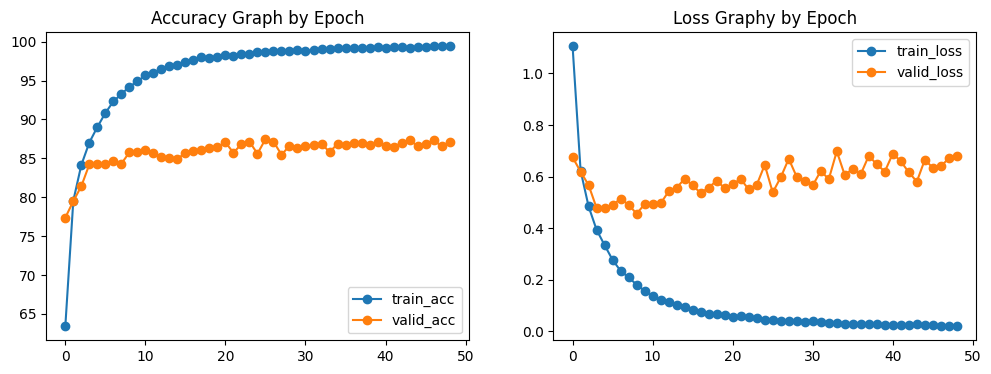

======================== Epoch: 50 ========================


100%|██████████| 4000/4000 [01:30<00:00, 44.01it/s]


Train loss: 0.019, Train acc: 99.4%


100%|██████████| 1000/1000 [00:07<00:00, 136.24it/s]


Valid loss: 0.658, Valid acc: 86.8%


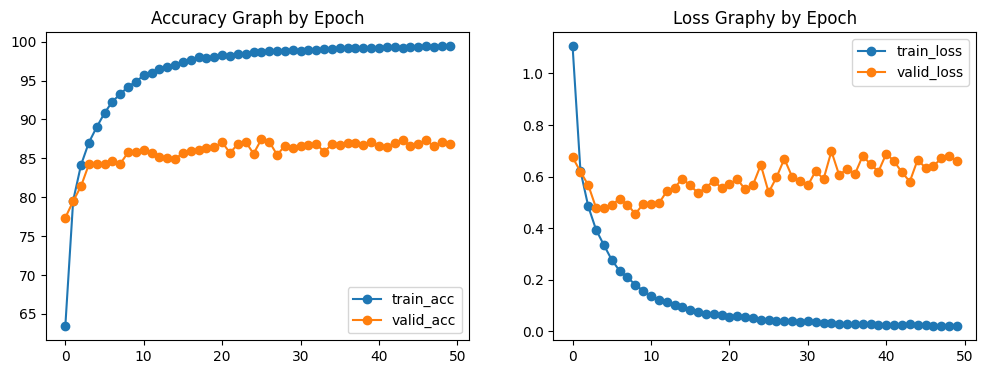

======================== Epoch: 51 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.92it/s]


Train loss: 0.020, Train acc: 99.4%


100%|██████████| 1000/1000 [00:07<00:00, 135.28it/s]


Valid loss: 0.683, Valid acc: 86.9%


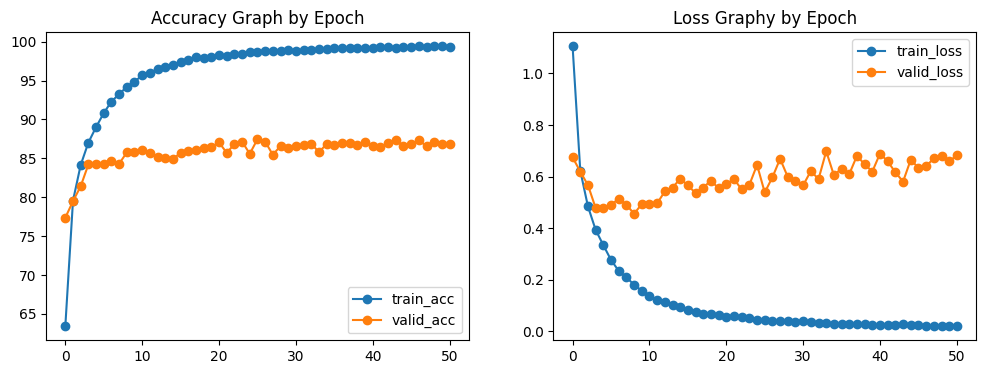

======================== Epoch: 52 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.93it/s]


Train loss: 0.019, Train acc: 99.4%


100%|██████████| 1000/1000 [00:07<00:00, 135.40it/s]


Valid loss: 0.636, Valid acc: 87.4%


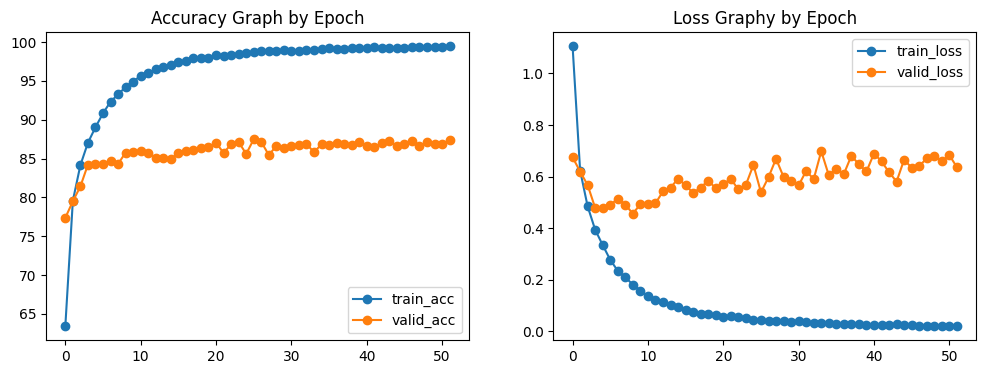

======================== Epoch: 53 ========================


100%|██████████| 4000/4000 [01:31<00:00, 43.85it/s]


Train loss: 0.016, Train acc: 99.5%


100%|██████████| 1000/1000 [00:07<00:00, 134.96it/s]


Valid loss: 0.657, Valid acc: 86.9%


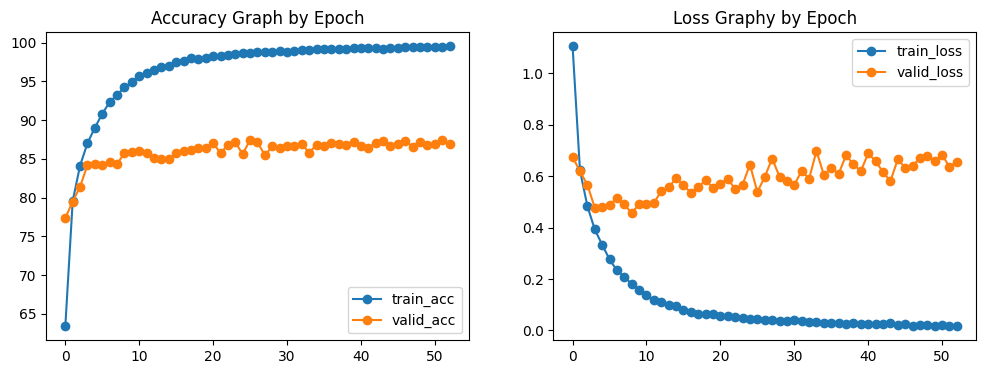

======================== Epoch: 54 ========================


 23%|██▎       | 908/4000 [00:20<01:10, 43.95it/s]


KeyboardInterrupt: 

In [22]:
valid_loss_min = np.Inf
train_epochs_loss = []
valid_epochs_loss = []
train_epochs_acc = []
valid_epochs_acc = []

for epoch in range(1, n_epochs+1):
    # Record train/valid loss and acc for each epoch
    train_loss_sum = 0.0
    valid_loss_sum = 0.0
    train_acc_num = 0.0
    valid_acc_num = 0.0
    # Start training and validating
    # ========================= train model =====================
    print('======================== Epoch: {} ========================'.format(epoch))
    model.train()
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * images.size(0)
        train_acc_num += sum(torch.max(logits, dim=1)[1] == labels).cpu()
    train_acc = 100 * train_acc_num/len(train_loader.dataset)
    train_loss = train_loss_sum/len(train_loader.dataset)
    train_epochs_loss.append(train_loss)
    train_epochs_acc.append(train_acc)
    print('Train loss: {:.3f}, Train acc: {:.1f}%'.format(train_loss, train_acc))

    # ========================= valid model =====================
    model.eval()
    for images, labels in tqdm(valid_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            loss = loss_fn(logits, labels)
        valid_loss_sum += loss.item() * images.size(0)
        valid_acc_num += sum(torch.max(logits, dim=1)[1] == labels).cpu()
    valid_acc= 100 * valid_acc_num/len(valid_loader.dataset)
    valid_loss = valid_loss_sum/len(valid_loader.dataset)
    valid_epochs_loss.append(valid_loss)
    valid_epochs_acc.append(valid_acc)
    print('Valid loss: {:.3f}, Valid acc: {:.1f}%'.format(valid_loss, valid_acc))

    # ========================= save model =====================
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.3f} --> {:.3f}).'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    # ========================= plot ==========================
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_epochs_acc, '-o', label="train_acc")
    plt.plot(valid_epochs_acc, '-o', label="valid_acc")
    plt.title("Accuracy Graph by Epoch")
    plt.legend()
    plt.subplot(122)
    plt.plot(train_epochs_loss, '-o', label="train_loss")
    plt.plot(valid_epochs_loss, '-o', label="valid_loss")
    plt.title("Loss Graphy by Epoch")
    plt.legend()
    plt.show()

## Testing

In [23]:
model.load_state_dict(torch.load('model_cifar.pt'))
cnf_matrix = torch.zeros(10, 10)
test_loss_sum = 0.0
test_acc_num = 0.0
# store the number of correct classified samples for each class
# and their total number
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
# Store 10 sample well-classified images and their confidence value
correct_classfied_flags = [False for i in range(10)]
correct_classfied_samples = [i for i in range(10)]
correct_classfied_values = [0 for i in range(10)]
correct_classfied_preds = [0 for i in range(10)]
# Store 10 sample miss-classified images and their confidence value
miss_classfied_flags = [False for i in range(10)]
miss_classfied_samples = [i for i in range(10)]
miss_classfied_values = [0 for i in range(10)]
miss_classfied_preds = [0 for i in range(10)]

model.eval()
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        logits = model(images)
        loss = loss_fn(logits, labels)
    test_loss_sum += loss.item() * images.size(0)
    pred = torch.max(logits, dim=1)[1]
    correct_tensor = pred == labels
    for idx in range(batch_size):
        # idx is the index of each image in one batch to RETRIVE from
        label = labels.data[idx].item()
        # label is the corresponding order of that image ot STORE in
        class_correct[label] += correct_tensor[idx].item()
        class_total[label] += 1
        if correct_tensor[idx] and not correct_classfied_flags[label]:
            correct_classfied_samples[label] = images.data[idx]
            correct_classfied_values[label] = max(nn.functional.softmax(logits[idx], dim=0)).item()
            correct_classfied_preds[label] = pred[idx].item()
            correct_classfied_flags[label] = True
        elif not correct_tensor[idx] and not miss_classfied_flags[label]:
            miss_classfied_samples[label] = images.data[idx]
            miss_classfied_values[label] = max(nn.functional.softmax(logits[idx], dim=0)).item()
            miss_classfied_preds[label] = pred[idx].item()
            miss_classfied_flags[label] = True   
    test_acc_num += sum(correct_tensor)
    cnf_matrix = confusion_matrix(pred, labels, cnf_matrix)

test_loss = test_loss_sum/len(test_loader.dataset)
test_acc = 100 * test_acc_num/len(test_loader.dataset)
print('Test Loss: {:.3f}, Test Acc: {:.1f}%'.format(test_loss, test_acc))
print('Test Accuracy by Class:')
for i in range(10):
    if class_total[i] > 0:
        print('{:8s}\t {:.1f}% ({:d}/{:d})'.format(class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

100%|██████████| 1000/1000 [00:08<00:00, 119.35it/s]

Test Loss: 0.462, Test Acc: 86.1%
Test Accuracy by Class:
airplane	 91.9% (919/1000)
automobile	 89.0% (890/1000)
bird    	 83.4% (834/1000)
cat     	 73.4% (734/1000)
deer    	 86.7% (867/1000)
dog     	 77.5% (775/1000)
frog    	 91.0% (910/1000)
horse   	 89.1% (891/1000)
ship    	 87.8% (878/1000)
truck   	 91.1% (911/1000)


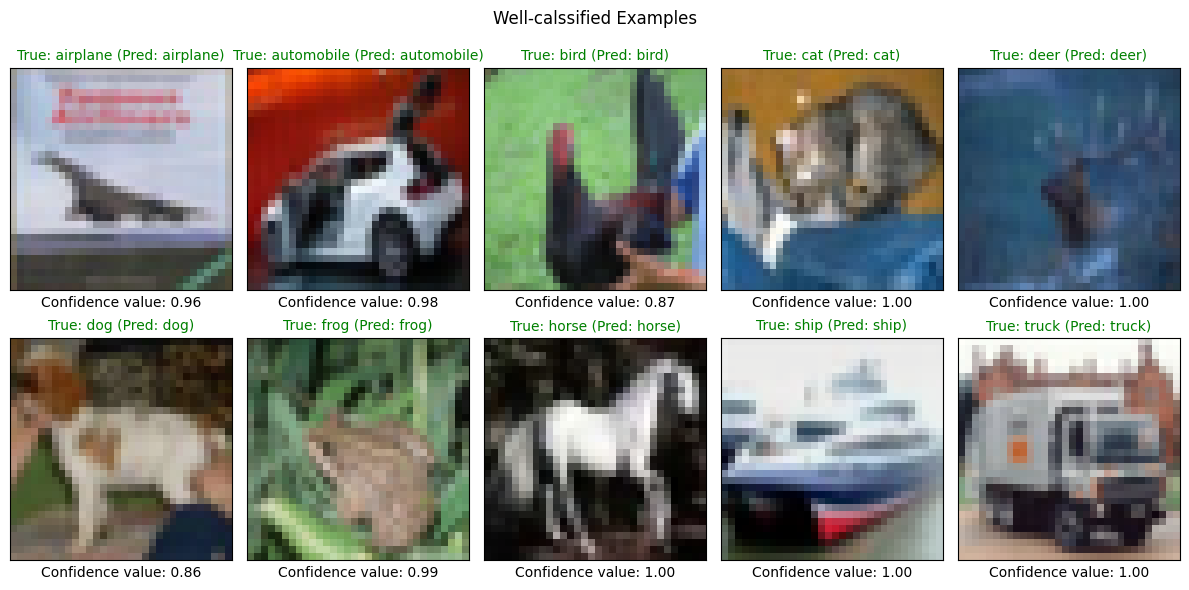

In [24]:
plot_class_samples(correct_classfied_samples, correct_classfied_preds, correct_classfied_values, title='Well-calssified Examples')

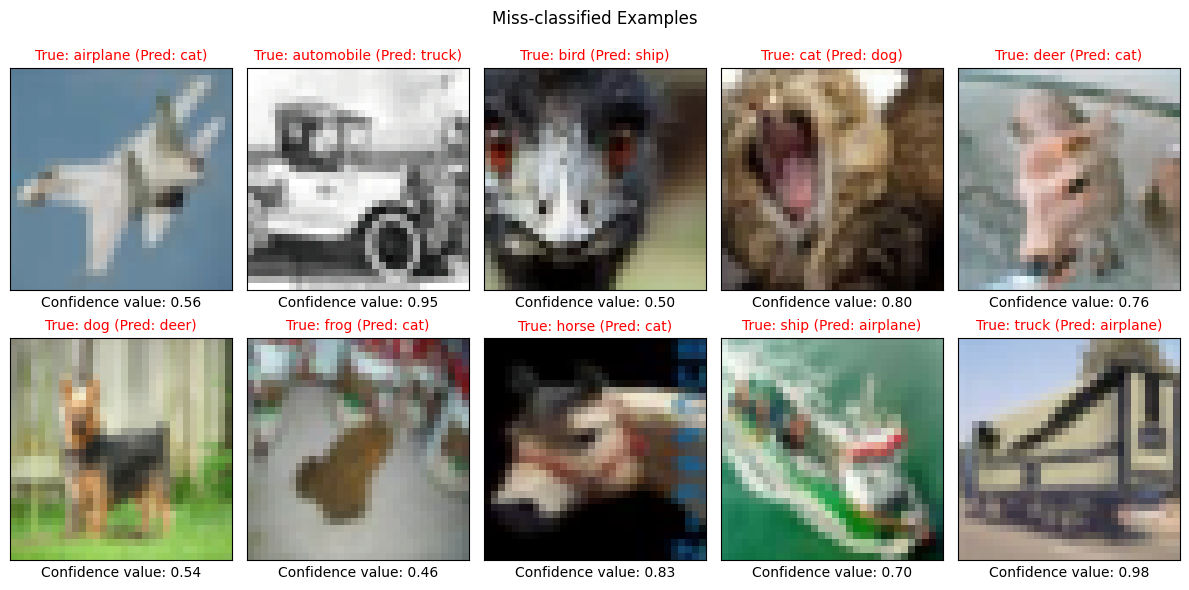

In [25]:
plot_class_samples(miss_classfied_samples, miss_classfied_preds, miss_classfied_values, title='Miss-classified Examples')

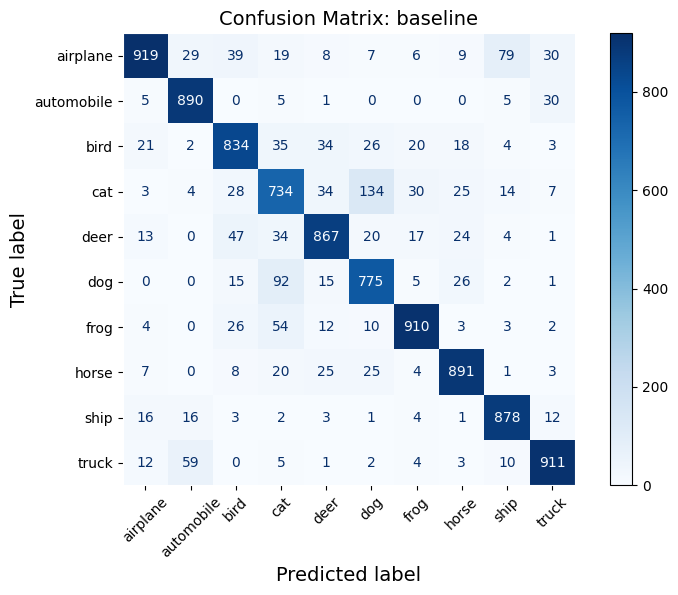

In [26]:
plot_confusion_matrix(cnf_matrix.numpy(), class_names, normalize=False, ax_display=False, title='Confusion Matrix: baseline')